<a href="https://colab.research.google.com/github/NasiluFred/Cassava_Leaves_classification/blob/main/Cassava_Leaves_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Updating the fastai library in google collab

In [ ]:
#|hide
#| eval: false
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

Install the fastcore and wwf libraries

In [ ]:
!pip install fastcore
!pip install wwf #Welcome to Walk with fastai library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.6 MB/s eta 0:00:00


Mount your google drive and navigate to your working folder (you should already know how to do this from the preparation sessions)

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 %cd '/content/drive/MyDrive'

/content/drive/MyDrive


Confirm that you are in the right folder

In [ ]:
!pwd

/content/drive/MyDrive


In [ ]:
!ls /content/drive/MyDrive/cassava_leaves_dsa_512

test  train


In [ ]:
classes  = ["cbsd", "cmd", "healthy", "Unknown"]



Import the required files from the fastai vision library

In [ ]:
from fastai.vision.all import *
#from fastai.metrics import


Check that dataset is OK and doesn't have any corrupted images

In [ ]:
image_folder = '/content/drive/MyDrive/cassava_leaves_dsa_512'
path = Path(image_folder)


In [ ]:
!ls '/content/drive/MyDrive/cassava_leaves_dsa_512/train/cbsd' | wc -l

500


In [ ]:
!ls '/content/drive/MyDrive/cassava_leaves_dsa_512/train/Unknown' | wc -l

500


In [ ]:
!ls '/content/drive/MyDrive/cassava_leaves_dsa_512/test/cbsd' | wc -l

50


In [ ]:
path

Path('/content/drive/MyDrive/cassava_leaves_dsa_512')

In [ ]:
# Check images

In [ ]:
imgs = L()
for n in classes:
  print(n)
  path_n = path/"train"/n
  imgs += verify_images(path_n.ls())

cbsd


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


cmd
healthy
Unknown


In [ ]:
imgs

(#0) []

## Create the dataloader

In [ ]:
leaves = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(0.2),
                  get_y=parent_label,
                  item_tfms=RandomResizedCrop(460),
                  batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

## TODO: Look into different augmentations

In [ ]:
dls = leaves.dataloaders(path,  bs=32)


## Look at your data (TODO: Run this a number of times)

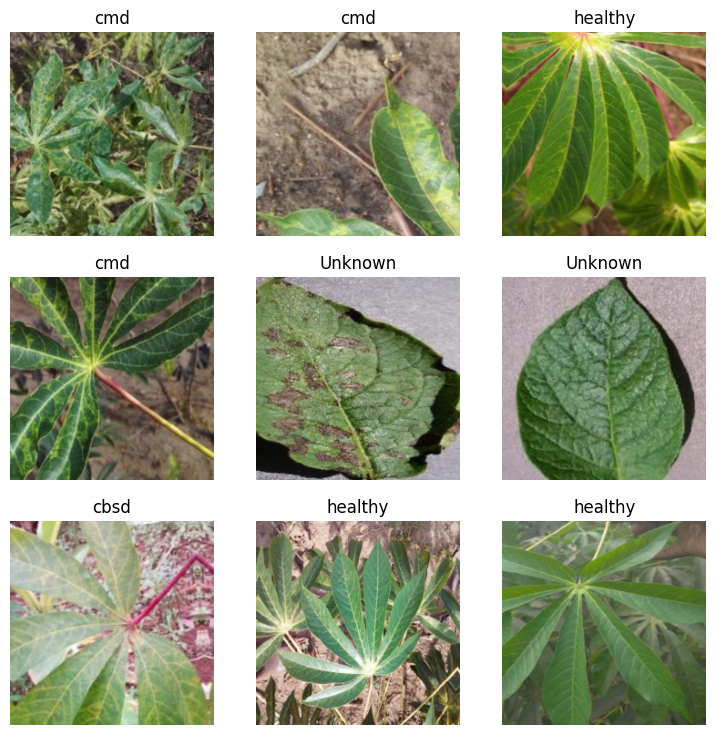

In [ ]:
dls.show_batch(max_n=9)


## The classes


In [ ]:
dls.vocab


['Unknown', 'cbsd', 'cmd', 'healthy']

The trainer

In [ ]:
## Create the trainer

In [ ]:
##learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[Precision]).to_fp16()


In [ ]:
# Import vision_learner instead of cnn_learner
from fastai.vision.learner import vision_learner

# Create the learner using vision_learner
learn = vision_learner(dls, resnet34, pretrained=True, metrics=[error_rate, accuracy]).to_fp16()

### Fit using one cycle (quickly find the best hyperparamers)

In [ ]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.124643,0.400904,0.136364,0.863636,00:22
1,0.639671,0.253069,0.088636,0.911364,00:24
2,0.438902,0.203802,0.084091,0.915909,00:25
3,0.361634,0.199816,0.070455,0.929545,00:24


## Save the the model for easy loading

In [ ]:
learn.save('stage-512-1')


Path('models/stage-512-1.pth')

### Unfreeze and fine tune at a smaller learning rate

In [ ]:
learn.unfreeze()


### Use the inbuild learning rate finder (for the unfrozen network)

SuggestedLRs(valley=0.0002290867705596611)

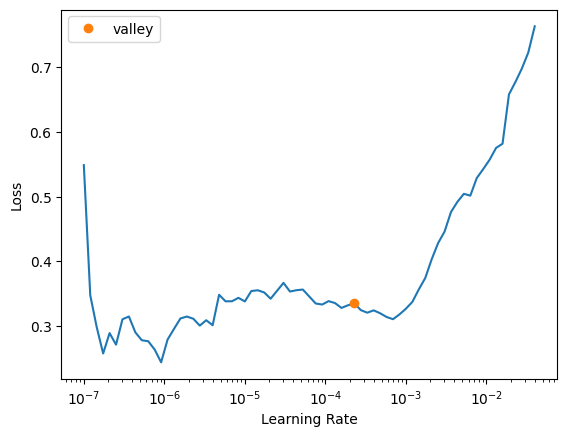

In [ ]:
learn.lr_find()


In [ ]:
learn.fit_one_cycle(4, lr_max=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.333798,0.986695,0.127273,0.872727,00:24
1,0.345493,0.160899,0.070455,0.929545,00:24
2,0.222245,0.095472,0.038636,0.961364,00:24
3,0.168591,0.088048,0.043182,0.956818,00:23


## TODO: Play around with different learning rates and number of epochs

Interpretation

In [ ]:
learn.save('stage-2-512')


Path('models/stage-2-512.pth')

In [ ]:
learn.load('stage-2-512');


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


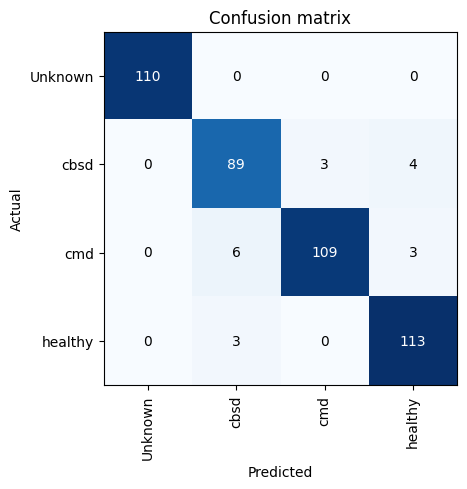

In [ ]:
interp.plot_confusion_matrix()


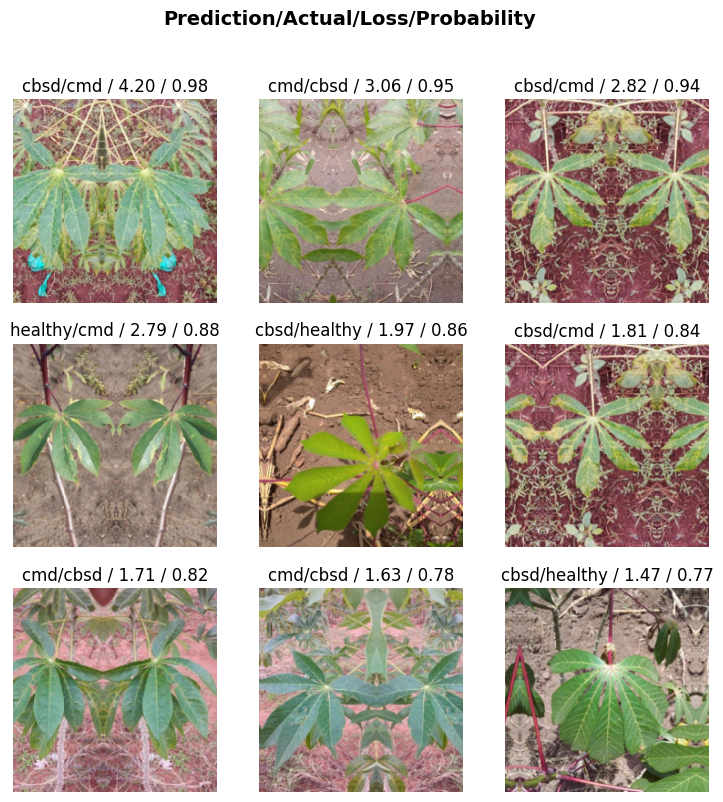

In [ ]:
interp.plot_top_losses(9, figsize=(9,9))


In [ ]:
#Exercise

- Change the pre-trained model
- Change the image size (advanced: progressively finetune on different image sizes)
- Deploy to hugging face
- Add un-known class
- Evaluate on a test set


##Change the pre-trained model

In [ ]:
# changing from resnet34 - resnet50

In [ ]:
# Import vision_learner instead of cnn_learner
from fastai.vision.learner import vision_learner

# Create the learner using vision_learner
learn = vision_learner(dls, resnet50, pretrained=True, metrics=[error_rate, accuracy]).to_fp16()

### Fit using one cycle (quickly find the best hyperparamers)

In [ ]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.923378,0.322157,0.102273,0.897727,00:24
1,0.587529,0.283602,0.100000,0.900000,00:24
2,0.465702,0.245891,0.090909,0.909091,00:23
3,0.387630,0.220761,0.075000,0.925000,00:24


## Save the the model for easy loading

In [ ]:
learn.save('resnet50-1')


Path('models/resnet50-1.pth')

### Unfreeze and fine tune at a smaller learning rate

In [ ]:
learn.unfreeze()


### Use the inbuild learning rate finder (for the unfrozen network)

SuggestedLRs(valley=0.00015848931798245758)

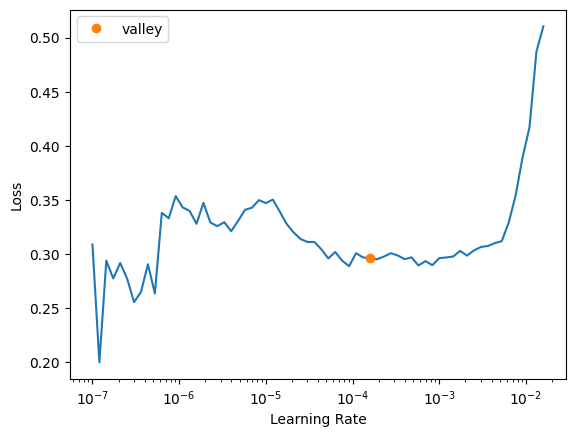

In [ ]:
learn.lr_find()


In [ ]:
learn.fit_one_cycle(4, lr_max=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.329491,0.294446,0.095455,0.904545,00:25
1,0.283007,0.105359,0.031818,0.968182,00:25
2,0.237115,0.079562,0.025000,0.975000,00:24
3,0.180042,0.054124,0.022727,0.977273,00:25


## TODO: Play around with different learning rates and number of epochs

Interpretation

In [ ]:
learn.save('resnet50-2')


Path('models/resnet50-2.pth')

In [ ]:
learn.load('resnet50-2');


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


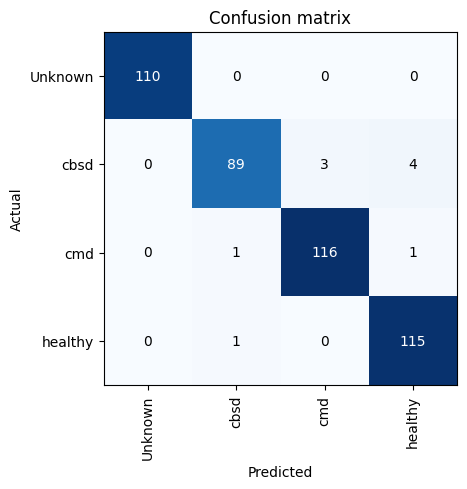

In [ ]:
interp.plot_confusion_matrix()


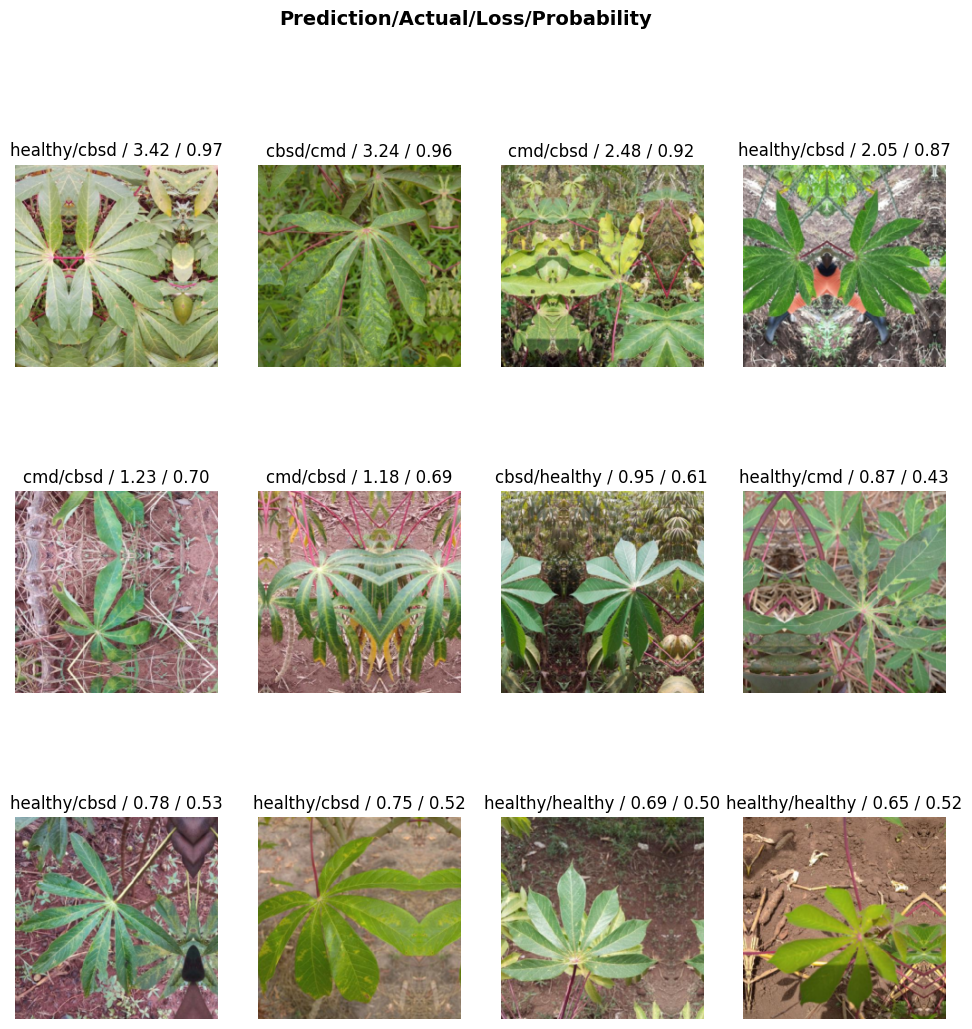

In [ ]:
interp.plot_top_losses(12, figsize=(12,12))


## Deployment on hugging face



In [ ]:
from huggingface_hub import push_to_hub_fastai
from huggingface_hub import notebook_login


notebook_login()


In [ ]:
push_to_hub_fastai(learner=learn, repo_id="NFN2/cassava_leaves_status")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.pkl:   0%|          | 0.00/87.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NFN2/cassava_leaves_status/commit/c4a3b98d575fd6c5cdee310084a31f11ec122be3', commit_message='Push FastAI model using huggingface_hub.', commit_description='', oid='c4a3b98d575fd6c5cdee310084a31f11ec122be3', pr_url=None, pr_revision=None, pr_num=None)

Use in fast ai

In [ ]:
from huggingface_hub import from_pretrained_fastai

learn = from_pretrained_fastai("NFN2/cassava_leaves_status")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

## Test on an external dataset

In [ ]:
test_folder = path/'test' # Replace 'test' with the name of your test folder
test_dl = dls.test_dl(get_image_files(test_folder), item_tfms=Resize(460))

In [ ]:
preds, _ = learn.get_preds(dl=test_dl) # Ignore ground truth labels since they are not available for test data
pred_classes = preds.argmax(dim=-1)
test_preds = []

for i, img_path in enumerate(test_dl.dataset.items):
    pred_class = dls.vocab[pred_classes[i]]
    test_preds.append((img_path, pred_class, preds[i]))

print(test_preds)


[(Path('/content/drive/MyDrive/cassava_leaves_dsa_512/test/cbsd/1616833319262.jpg'), 'cbsd', tensor([5.8252e-06, 9.7595e-01, 1.9982e-02, 4.0659e-03])), (Path('/content/drive/MyDrive/cassava_leaves_dsa_512/test/cbsd/1617103812795.jpg'), 'cbsd', tensor([0.0043, 0.6452, 0.2731, 0.0773])), (Path('/content/drive/MyDrive/cassava_leaves_dsa_512/test/cbsd/1617099943864.jpg'), 'cbsd', tensor([2.2475e-06, 9.9681e-01, 3.1832e-03, 4.5147e-06])), (Path('/content/drive/MyDrive/cassava_leaves_dsa_512/test/cbsd/1617103843642.jpg'), 'cbsd', tensor([2.1670e-04, 9.9343e-01, 6.1207e-03, 2.3456e-04])), (Path('/content/drive/MyDrive/cassava_leaves_dsa_512/test/cbsd/1617099222286.jpg'), 'cbsd', tensor([6.1470e-04, 6.2938e-01, 3.6975e-01, 2.5631e-04])), (Path('/content/drive/MyDrive/cassava_leaves_dsa_512/test/cbsd/1616854309992.jpg'), 'cmd', tensor([1.2039e-05, 1.0947e-02, 9.8900e-01, 4.4291e-05])), (Path('/content/drive/MyDrive/cassava_leaves_dsa_512/test/cbsd/1617104566099.jpg'), 'cbsd', tensor([4.6197e-07